# Strategy Overview

I will be creating a trading strategy that utilizes the base of the Parabolic Stop and Reserve (SAR) strategy along with the RSI indicator. Both of these indicators are relatively long term, so I will be aiming for a strategy that generates returns over a 3-5 year period. Below is the steps I have taken to implement this strategy.
1. Clean Stock Data
2. Implement Parabolic SAR strategy.
3. Implement the Relative Strength Index (RSI)
4. Find signals supported by both indicators.
5. Calculate Returns
6. Plot data and returns
7. Backtest all data
8. Determine strategy effectiveness using the Sharpe Ratio and Information Ratio

## Imports

In [1382]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from datetime import datetime
from collections import deque
import pytz

## **1. Clean and Analyze Stock data in different periods**

In [1385]:
# Function to fill empty columns with a rolling mean
def fill_missing_with_rolling_mean(data, window=10):
    for column in data.columns:
        data[column] = data[column].fillna(data[column].rolling(window=window, min_periods=1).mean())
    return data

def clean_data(ticker, start, end, interval='1d'):
    # Download stock data
    data = yf.download(ticker, start=start, end=end, interval=interval)

    # Filter intraday data between market hours 09:30 and 16:00
    if interval.endswith('m'):  # For intraday data, filter to market hours 09:30 to 16:00
        data = data.between_time('09:30', '16:00')

    # Step 1: Fill missing data using the mean of the most recent 10 data points
    data = fill_missing_with_rolling_mean(data, window=10)


    # Step 2: Remove duplicate data
    data = data.drop_duplicates()

    # outliers currenlty causing some issues and removing first 7 values
    # Step 3: Handle outliers using Z-scores
    z_scores = np.abs(stats.zscore(data['Close']))
    threshold = 3  # Typically a Z-score above 3 is considered an outlier
    data = data[(z_scores < threshold)]  # Filter out outliers


    # The remaining data cleaning considerations (incorrect timestamps, corporate actions, and data inconsistencies) can be ignored
    # Incorrect timestamps and data inconsistencies will not occur as all data is from the same source
    # Additionally, corporate actions are handled by yfinance

    return data


# function to get tick marks for intraday trading
def get_ticks(data, interval='1d'):
    # print(data.index)
    result = []
    if interval.endswith('m'):
        result = [dt.strftime('%H:%M') for dt in data.index]
    return result
        
        
# old function to analuze stocks
def analyze_stocks(data, ticker, interval='1d'):
    plt.figure(figsize=(10, 5))
    
    # Plot the 'Close' price
    plt.plot(data['Close'], label=f'{ticker} Close Price')
    
    # Get the current axis
    ax = plt.gca()

    # Set x-axis major formatter to display date for daily data
    if interval == '1d':
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif interval.endswith('m'):  # For intraday data (minute-level)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate the x-axis labels for better readability
    plt.gcf().autofmt_xdate()

    # Add title and legend
    plt.title(f'{ticker} Price')
    plt.legend()

    if interval.endswith('m'):
        plt.title(f"{ticker} Intraday Price for {data.index[0].strftime('%B %d, %Y')}")
        # Define the desired times for x-ticks
        desired_times = ["09:30", "10:00", "10:30", "11:00", "11:30", "12:00", 
                         "12:30", "13:00", "13:30", "14:00", "14:30", "15:00", 
                         "15:30", "16:00"]

        # Filter the data.index to match the desired times
        xticks = [dt for dt in data.index if dt.strftime('%H:%M') in desired_times]
        
        ax.set_xticks(xticks)

        # Set corresponding x-tick labels (format the labels as 'Hour:Minute')
        ax.set_xticklabels([dt.strftime('%H:%M') for dt in xticks])

    # Show the plot
    plt.show()

## **2. Create a basic implementation of the Parabolic Stop and Reverse Strategy**

### **2.1 Parabolic SAR Class**

In [1389]:
class PSAR:
    # PSAR (Parabolic Stop and Reverse) initialization
    def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
        self.max_af = max_af  # maximum acceleration factor
        self.init_af = init_af  # initial acceleration factor
        self.af = init_af  # current acceleration factor
        self.af_step = af_step  # acceleration factor increment step
        self.extreme_point = None  # stores the extreme point (high/low price)
        self.high_price_trend = []  # list to track high prices in an uptrend
        self.low_price_trend = []  # list to track low prices in a downtrend
        self.high_price_window = deque(maxlen=2)  # sliding window for last 2 high prices
        self.low_price_window = deque(maxlen=2)  # sliding window for last 2 low prices

        # Lists to store computed PSAR, AF (acceleration factor), EP (extreme point), trend direction, etc.
        self.psar_list = []
        self.af_list = []
        self.ep_list = []
        self.trend_list = []
        self.high_list = []
        self.low_list = []
        self._num_days = 0  # track the number of days processed

    # Main function to calculate the PSAR for a given day's high and low prices
    def calcPSAR(self, high, low):
        if self._num_days >= 3:
            psar = self._calcPSAR()  # calculate PSAR after initialization period
        else:
            psar = self._initPSARVals(high, low)  # initialize PSAR for the first 3 days

        psar = self._updateCurrentVals(psar, high, low)  # update with current day's values
        self._num_days += 1  # increment day counter

        return psar

    # Initialize PSAR values during the first few days
    def _initPSARVals(self, high, low):
        if len(self.low_price_window) <= 1:
            self.trend = None  # not enough data to determine trend
            self.extreme_point = high  # set extreme point to current high
            return None

        # Determine initial trend direction based on the price movement
        if self.high_price_window[0] < self.high_price_window[1]:
            self.trend = 1  # uptrend
            psar = min(self.low_price_window)  # PSAR starts at lowest low
            self.extreme_point = max(self.high_price_window)  # extreme point is the highest high
        else:
            self.trend = 0  # downtrend
            psar = max(self.high_price_window)  # PSAR starts at highest high
            self.extreme_point = min(self.low_price_window)  # extreme point is the lowest low

        return psar

    # Calculate PSAR after initialization period (day 4 and onwards)
    def _calcPSAR(self):
        prev_psar = self.psar_list[-1]  # get previous day's PSAR
        if self.trend == 1:  # uptrend
            psar = prev_psar + self.af * (self.extreme_point - prev_psar)  # adjust PSAR upwards
            psar = min(psar, min(self.low_price_window))  # ensure PSAR doesn't exceed the low price
        else:  # downtrend
            psar = prev_psar - self.af * (prev_psar - self.extreme_point)  # adjust PSAR downwards
            psar = max(psar, max(self.high_price_window))  # ensure PSAR doesn't go below the high price

        return psar

    # Update current values (PSAR, AF, trend, etc.) for the given day
    def _updateCurrentVals(self, psar, high, low):
        if self.trend == 1:
            self.high_price_trend.append(high)  # track high prices during uptrend
        elif self.trend == 0:
            self.low_price_trend.append(low)  # track low prices during downtrend

        psar = self._trendReversal(psar, high, low)  # check if trend reversal occurred

        # Update the tracking lists with new values
        self.psar_list.append(psar)
        self.af_list.append(self.af)
        self.ep_list.append(self.extreme_point)
        self.trend_list.append(self.trend)
        self.high_list.append(high)
        self.low_list.append(low)
        self.high_price_window.append(high)  # update the high price window
        self.low_price_window.append(low)  # update the low price window

        return psar

    # Check and handle trend reversals (from uptrend to downtrend or vice versa)
    def _trendReversal(self, psar, high, low):
        reversal = False
        if self.trend == 1 and psar > low:  # uptrend reversal if PSAR exceeds current low
            self.trend = 0  # switch to downtrend
            psar = max(self.high_price_trend)  # reset PSAR to highest high during uptrend
            self.extreme_point = low  # set new extreme point to current low
            reversal = True
        elif self.trend == 0 and psar < high:  # downtrend reversal if PSAR drops below current high
            self.trend = 1  # switch to uptrend
            psar = min(self.low_price_trend)  # reset PSAR to lowest low during downtrend
            self.extreme_point = high  # set new extreme point to current high
            reversal = True

        # If a reversal occurred, reset the AF and trend-tracking lists
        if reversal:
            self.af = self.init_af  # reset acceleration factor
            self.high_price_trend.clear()  # clear high price trend
            self.low_price_trend.clear()  # clear low price trend
        else:
            # If no reversal, check for new extreme points and adjust AF
            if high > self.extreme_point and self.trend == 1:  # new high in uptrend
                self.af = min(self.af + self.af_step, self.max_af)  # increase AF within bounds
                self.extreme_point = high  # update extreme point
            elif low < self.extreme_point and self.trend == 0:  # new low in downtrend
                self.af = min(self.af + self.af_step, self.max_af)  # increase AF within bounds
                self.extreme_point = low  # update extreme point

        return psar


### **2.2 Parabolic SAR Plot and Signals**

In [1392]:
# Calculate PSAR data for a given ticker's price data
def get_psar_data(prices, ticker, af_start=0.02, increment=0.02, af_max=0.20):
    obj = PSAR()  # Initialize the PSAR object with default parameters

    # Apply the PSAR calculation to each row of the 'prices' DataFrame using the high and low prices
    prices['PSAR'] = prices.apply(
        lambda x: obj.calcPSAR(x['High'], x['Low']), axis=1)

    # Store the extreme points, trend direction, and acceleration factors in the DataFrame
    prices['EP'] = pd.Series(obj.ep_list, index=prices.index)
    prices['Trend'] = pd.Series(obj.trend_list, index=prices.index)
    prices['AF'] = pd.Series(obj.af_list, index=prices.index)

    # Separate PSAR data for bull (uptrend) and bear (downtrend) trends
    psar_bull = prices.loc[prices['Trend'] == 1]['PSAR']  # PSAR values during uptrend
    psar_bear = prices.loc[prices['Trend'] == 0]['PSAR']  # PSAR values during downtrend

    # Identify buy signals when the trend changes to an uptrend
    buy_sigs = prices.loc[prices['Trend'].diff() == 1]['Close']

    # Identify short signals when the trend changes to a downtrend
    short_sigs = prices.loc[prices['Trend'].diff() == -1]['Close']

    # Create a DataFrame to store PSAR trend data, buy signals, and short signals
    psar_data = pd.DataFrame({
        'psar_bull': psar_bull,
        'psar_bear': psar_bear,
        'buy_sigs': buy_sigs,
        'short_sigs': short_sigs
    })

    return psar_data  # Return the PSAR data


# Plot the PSAR and price data for a given ticker
def plot_parabolic_sar(prices, psar_data, ticker):
    
    # Extract PSAR trends and signals from the psar_data DataFrame
    psar_bull = psar_data['psar_bull']  # PSAR during uptrend
    psar_bear = psar_data['psar_bear']  # PSAR during downtrend
    buy_sigs = psar_data['buy_sigs']  # Buy signals (uptrend starts)
    short_sigs = psar_data['short_sigs']  # Short signals (downtrend starts)

    # Define colors from matplotlib's default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Create a plot of the closing price with PSAR trends and buy/short signals
    plt.figure(figsize=(12, 8))
    plt.plot(prices['Close'], label='Close', linewidth=1, zorder=0)  # Plot the closing prices

    # Plot buy signals as upward green arrows
    plt.scatter(buy_sigs.index, buy_sigs, color=colors[2], 
                label='Buy', marker='^', s=100)

    # Plot short signals as downward red arrows
    plt.scatter(short_sigs.index, short_sigs, color=colors[4], 
                label='Short', marker='v', s=100)

    # Plot PSAR values during uptrend and downtrend
    plt.scatter(psar_bull.index, psar_bull, color=colors[1], label='Up Trend')
    plt.scatter(psar_bear.index, psar_bear, color=colors[3], label='Down Trend')

    # Label the plot with axis titles and a legend
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'{ticker} Price and Parabolic SAR')
    plt.legend()

    # Display the plot
    plt.show()


## **3. Develop the Relative Strength Index**

### **3.1 Get RSI Values**

In [1396]:
def calculate_rsi(prices, period=14):
    # Calculate the daily price differences
    change = prices.diff()
    
    # Separate the gains (positive changes) and losses (negative changes)
    gain = change.clip(lower=0)
    loss = -change.clip(upper=0)
    
    # Calculate the rolling average of gains and losses over the specified period
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Calculate the relative strength (RS) and then the RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi  # Return the calculated RSI values


def rsi_list(data, ticker='Unknown', period=14, oversold=30, overbought=70):
    # Ensure that the DataFrame has a 'Close' column
    if 'Close' not in data.columns:
        raise ValueError("The input DataFrame must contain a 'Close' column.")
    
    # Calculate the RSI for the 'Close' prices
    rsi_values = calculate_rsi(data['Close'], period)

    # Create buy signals when RSI crosses above the oversold threshold
    buy_sigs = ((rsi_values < oversold) & (rsi_values.shift(1) >= oversold))

    # Create short signals when RSI crosses below the overbought threshold
    short_sigs = ((rsi_values > overbought) & (rsi_values.shift(1) <= overbought))
    
    # Add the calculated RSI values to the original DataFrame
    data['rsi_values'] = rsi_values

    # Create a DataFrame for buy and short signals
    rsi_signals = pd.DataFrame({
        'buy_sigs': buy_sigs,
        'short_sigs': short_sigs
    })
    
    return rsi_signals  # Return the RSI signals (buy and short)


### **3.2 Plot RSI Data**

In [1399]:
# function to plot only RSI data
def plot_rsi(data, ticker='Unknown', period=14, oversold=30, overbought=70):
    
    # Set up the plot
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10, 6))

    # Create subplots: Price and RSI
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot the 'Close' prices
    ax1.plot(data.index, data['Close'], label=f'{ticker} Close Price', color='blue')
    ax1.set_title(f'{ticker} Close Price')
    ax1.legend()

    # Plot the RSI values
    ax2.plot(data.index, rsi_values, label='RSI', color='orange')
    ax2.axhline(y=oversold, color='green', linestyle='--', label='Oversold')
    ax2.axhline(y=overbought, color='red', linestyle='--', label='Overbought')
    ax2.set_title('Relative Strength Index')
    ax2.legend()

    # Display the plot
    plt.show()

## **4. Find resulting Signals**

In [1402]:
# function to print all relevant signals
def print_valid_signals(signals):
    # Filter the DataFrame to only include rows where either buy or short signal is True
    valid_signals = signals[(signals['final_buy_sigs'] == True) | (signals['final_short_sigs'] == True)]
    
    # Print the filtered valid signals
    print(valid_signals)

# combines signal from psar and rsi
def create_signals(prices, psar_data, rsi_signals, window=5):
    # Make copies of the PSAR and RSI signals data
    psar_data2 = psar_data.copy()
    rsi_signals2 = rsi_signals.copy()
    
    # Drop the PSAR trend columns ('psar_bull' and 'psar_bear') as they aren't needed for signals
    psar_data2.drop(['psar_bull', 'psar_bear'], axis=1, inplace=True)

    # Convert buy/short signals to True/False, where True indicates a signal is present
    psar_data2['buy_sigs'] = psar_data2['buy_sigs'].notna()
    psar_data2['short_sigs'] = psar_data2['short_sigs'].notna()

    # Create a DataFrame combining PSAR and RSI buy and short signals
    signals = pd.DataFrame({
        'psar_buy_sigs': psar_data2['buy_sigs'],
        'psar_short_sigs': psar_data2['short_sigs'],
        'rsi_buy_sigs': rsi_signals2['buy_sigs'],
        'rsi_short_sigs': rsi_signals2['short_sigs'],
    })

    # Separate DataFrames for buy and short signals from both PSAR and RSI
    buy_signals = pd.DataFrame({
        'psar_buy_sigs': psar_data2['buy_sigs'],
        'rsi_buy_sigs': rsi_signals2['buy_sigs'],
    })

    short_signals = pd.DataFrame({
        'psar_short_sigs': psar_data2['short_sigs'],
        'rsi_short_sigs': rsi_signals2['short_sigs'],
    })

    final_buy_sigs = []  # List to store final buy signals
    final_short_sigs = []  # List to store final short signals
    n = len(signals['psar_buy_sigs'])  # Total number of rows (signals)

    # Loop through the signals and look for matching PSAR and RSI signals within the window
    for i in range(n):
        start_index = max(0, i - window)  # Start of the window
        end_index = min(n, i + window + 1)  # End of the window

        # Handle buy signals
        if signals['psar_buy_sigs'].iloc[i]:
            # Check for nearby RSI buy signals within the window
            rsi_buy_sigs = signals.iloc[start_index:end_index]['rsi_buy_sigs'].values
            index = np.where(rsi_buy_sigs == True)[0]

            if len(index) > 0:  # If a match is found
                final_buy_sigs.append(True)
                # Mark the matched RSI signal as used to avoid reuse
                signals.loc[signals.index[start_index + index[0]], 'rsi_buy_sigs'] = False
            else:
                final_buy_sigs.append(False)
        else:
            final_buy_sigs.append(False)

        # Handle short signals
        if signals['psar_short_sigs'].iloc[i]:
            # Check for nearby RSI short signals within the window
            rsi_short_sigs = signals.iloc[start_index:end_index]['rsi_short_sigs'].values
            index = np.where(rsi_short_sigs == True)[0]

            if len(index) > 0:  # If a match is found
                final_short_sigs.append(True)
                # Mark the matched RSI signal as used to avoid reuse
                signals.loc[signals.index[start_index + index[0]], 'rsi_short_sigs'] = False
            else:
                final_short_sigs.append(False)
        else:
            final_short_sigs.append(False)

    # Drop the intermediate PSAR and RSI signals columns
    signals.drop(['psar_buy_sigs', 'psar_short_sigs', 'rsi_buy_sigs', 'rsi_short_sigs'], axis=1, inplace=True)

    # Add the final buy and short signals to the DataFrame
    signals['final_buy_sigs'] = final_buy_sigs
    signals['final_short_sigs'] = final_short_sigs

    return signals  # Return the DataFrame with final signals


## **5. Get Returns**

In [1405]:
def generate_returns(data, initial_capital=100000):
    # Initialize variables to track the number of shares, buy/sell prices, and capital
    shares = 0
    buyPrice = 0
    sellPrice = 0
    capital = initial_capital  # Starting capital
    value = capital  # Current value of portfolio (capital + stock value if any)

    # List to track returns as a percentage over time
    returns = []

    n = len(data['final_buy_sigs'])  # Total number of rows in the data

    # Loop through each row in the data to process buy and short signals
    for i in range(n):
        # Get buy/short signals and relevant price data for the current row
        buy = data['final_buy_sigs'].iloc[i]
        short = data['final_short_sigs'].iloc[i]
        close = data['Close'].iloc[i]  # Use close price for buying/selling decisions

        # If a buy signal is present and no shares are currently held
        if buy and shares == 0:
            buyPrice = close  # Set the buy price to the current close price
            sellPrice = 0  # Reset the sell price
            shares = value / buyPrice  # Buy as many shares as possible with available capital
            capital = 0  # All capital is now in shares

        # If a short (sell) signal is present and shares are currently held
        elif short and shares > 0:
            buyPrice = 0  # Reset the buy price
            sellPrice = close  # Set the sell price to the current close price
            capital = sellPrice * shares  # Sell all shares and convert to capital
            shares = 0  # No more shares held

        # Update the current value of the portfolio (capital or stock value)
        value = capital if shares == 0 else shares * close
        
        # Calculate the return as a percentage of the initial capital
        percent_change = ((value - initial_capital) / initial_capital) * 100
        returns.append(percent_change)  # Append the percentage change to the returns list

    # Add the returns as a new column in the DataFrame
    data['returns'] = returns
    return


## **6. Plotting**

In [1408]:
def plot_both(prices, ticker, psar_data, rsi_signals, oversold=30, overbought=70):
    # Extract relevant PSAR data: bullish trend, bearish trend, buy signals, and short signals
    psar_bull = psar_data['psar_bull']
    psar_bear = psar_data['psar_bear']
    psar_buy_sigs = psar_data['buy_sigs']
    psar_short_sigs = psar_data['short_sigs']

    # Extract RSI buy and short signals
    rsi_buy_sigs = rsi_signals['buy_sigs']
    rsi_short_sigs = rsi_signals['short_sigs']

    # Extract the RSI values from the prices data
    rsi_values = prices['rsi_values']

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get the default color cycle

    # Create subplots: Price and PSAR in the first, RSI in the second
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot Close price and PSAR signals in the first subplot (ax1)
    ax1.plot(prices['Close'], label=f'{ticker} Close Price', color='blue', linewidth=1.5, zorder=0)
    ax1.scatter(psar_buy_sigs.index, psar_buy_sigs, color=colors[2], label='Buy', marker='^', s=100)  # PSAR Buy signals
    ax1.scatter(psar_short_sigs.index, psar_short_sigs, color=colors[4], label='Short', marker='v', s=100)  # PSAR Short signals
    ax1.scatter(psar_bull.index, psar_bull, color=colors[1], label='Up Trend')  # PSAR uptrend
    ax1.scatter(psar_bear.index, psar_bear, color=colors[3], label='Down Trend')  # PSAR downtrend
    ax1.set_ylabel('Price ($) and Parabolic SAR')  # Set y-axis label
    ax1.legend(loc='upper left')  # Set legend location

    # Plot the RSI values in the second subplot (ax2)
    ax2.plot(prices.index, rsi_values, color='orange', label='RSI', linewidth=1.5)
    ax2.axhline(y=oversold, color='green', linestyle='--', label='Oversold', linewidth=1.5)  # Oversold line
    ax2.axhline(y=overbought, color='red', linestyle='--', label='Overbought', linewidth=1.5)  # Overbought line
    ax2.set_ylabel('RSI')  # Set y-axis label for RSI
    ax2.set_xlabel('Date')  # Set x-axis label
    ax2.legend(loc='upper right')  # Set legend location

    # Add a title to the entire figure
    fig.suptitle(f'{ticker} - Price, Parabolic SAR, and RSI')

    # Show the plot
    plt.show()


def plot_returns(prices, ticker, psar_data, rsi_signals, oversold=30, overbought=70):
    # Extract relevant PSAR data: bullish trend, bearish trend, buy signals, and short signals
    psar_bull = psar_data['psar_bull']
    psar_bear = psar_data['psar_bear']
    psar_buy_sigs = psar_data['buy_sigs']
    psar_short_sigs = psar_data['short_sigs']

    # Extract RSI buy and short signals
    rsi_buy_sigs = rsi_signals['buy_sigs']
    rsi_short_sigs = rsi_signals['short_sigs']

    # Extract the RSI values and returns from the prices data
    rsi_values = prices['rsi_values']
    returns = prices['returns']  # Assuming 'returns' column exists

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get the default color cycle

    # Create subplots: Close price and PSAR with Returns, RSI on a separate subplot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Plot Close price and PSAR signals in the first subplot (ax1)
    ax1.plot(prices['Close'], label=f'{ticker} Close Price', color='blue', linewidth=1.5, zorder=0)
    ax1.scatter(psar_buy_sigs.index, psar_buy_sigs, color=colors[2], label='PSAR Buy', marker='^', s=100)  # PSAR Buy signals
    ax1.scatter(psar_short_sigs.index, psar_short_sigs, color=colors[4], label='PSAR Short', marker='v', s=100)  # PSAR Short signals
    ax1.scatter(psar_bull.index, psar_bull, color=colors[1], label='Up Trend', s=10)  # PSAR uptrend
    ax1.scatter(psar_bear.index, psar_bear, color=colors[3], label='Down Trend', s=10)  # PSAR downtrend
    ax1.set_ylabel('Price ($) and Parabolic SAR')  # Set y-axis label
    ax1.legend(loc='upper left')  # Set legend location

    # Create a secondary y-axis for plotting Returns on the same subplot
    ax1_2 = ax1.twinx()
    ax1_2.plot(prices.index, returns, color='purple', label='Returns (%)', linewidth=1.5)  # Plot returns
    ax1_2.set_ylabel('Returns (%)', color='purple')  # Set y-axis label for returns
    ax1_2.legend(loc='upper right')  # Set legend location

    # Plot the RSI values in the second subplot (ax2)
    ax2.plot(prices.index, rsi_values, color='orange', label='RSI', linewidth=1.5)
    ax2.axhline(y=oversold, color='green', linestyle='--', label='Oversold', linewidth=1.5)  # Oversold line
    ax2.axhline(y=overbought, color='red', linestyle='--', label='Overbought', linewidth=1.5)  # Overbought line
    ax2.set_ylabel('RSI')  # Set y-axis label for RSI
    ax2.set_xlabel('Date')  # Set x-axis label
    ax2.legend(loc='upper right')  # Set legend location

    # Add a title to the entire figure
    fig.suptitle(f'{ticker} - Price, Parabolic SAR, RSI, and Returns')

    # Show the plot
    plt.show()


## **7. Testing**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Sharpe Ratio: 2.305394171807805
Information Ratio: 2.3138593185149374


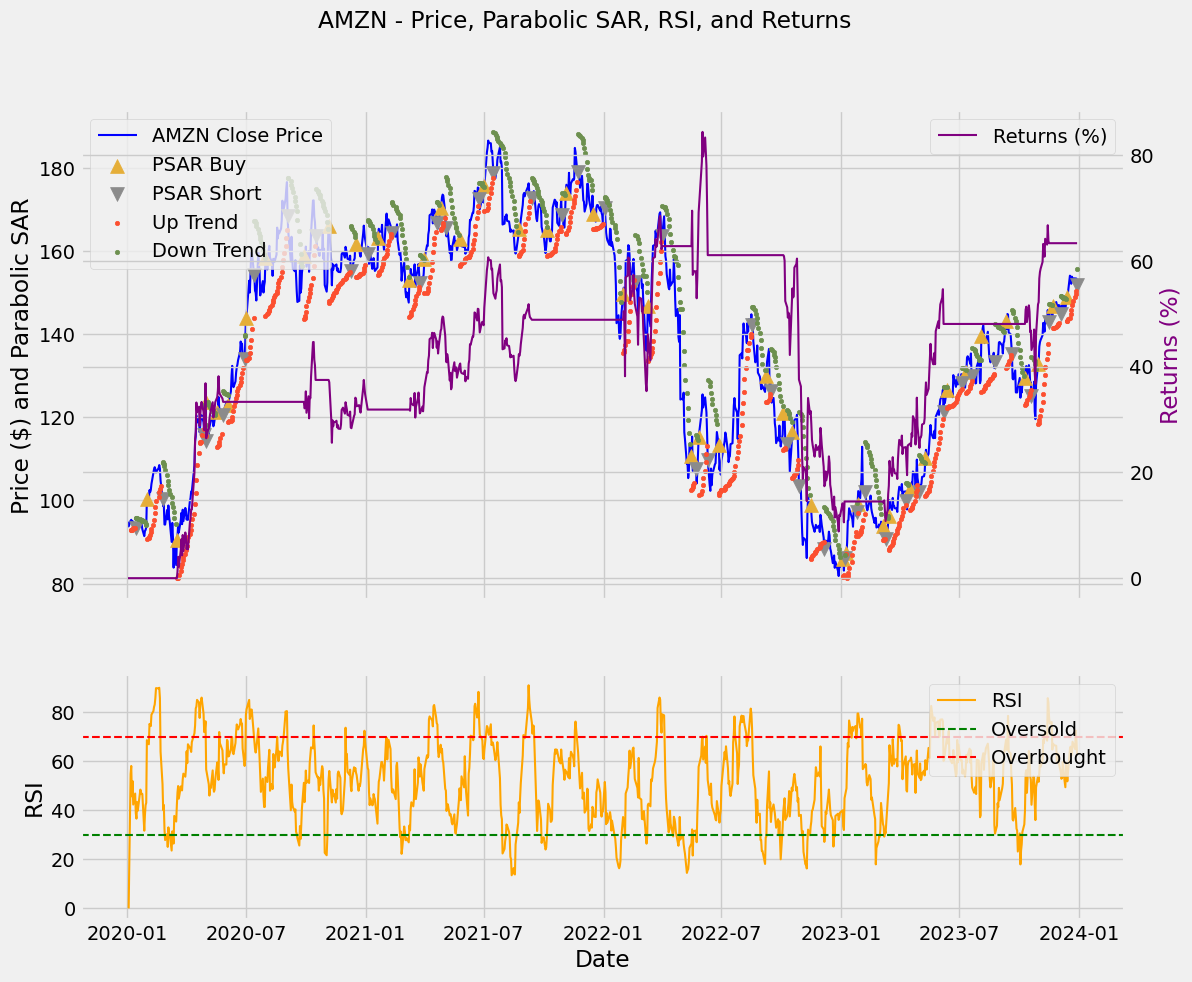

[*********************100%***********************]  1 of 1 completed


Sharpe Ratio: 2.0987645361267586
Information Ratio: 2.104981555153252


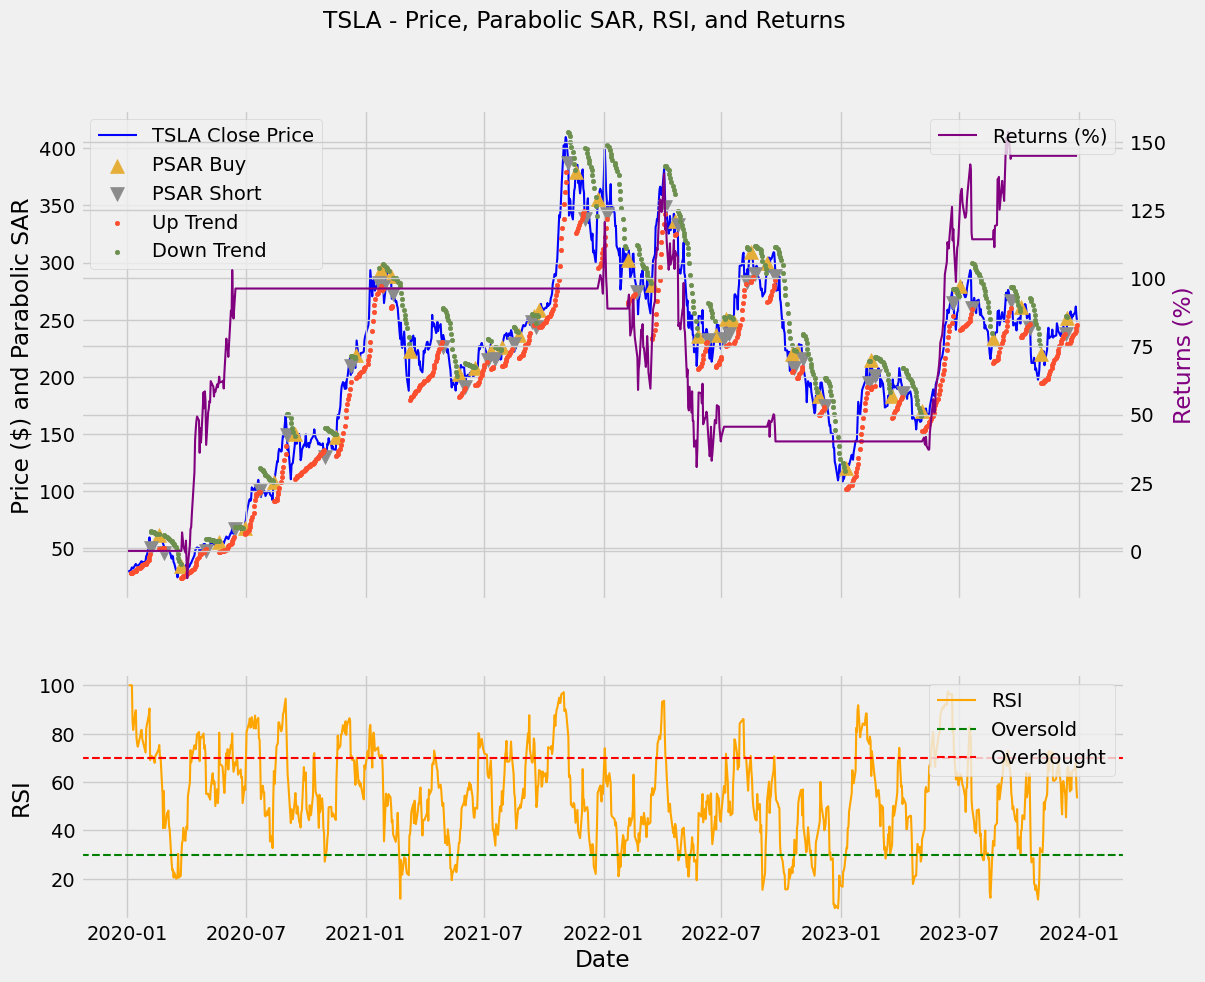

[*********************100%***********************]  1 of 1 completed


Sharpe Ratio: 1.4094296121690892
Information Ratio: 1.412758101923929


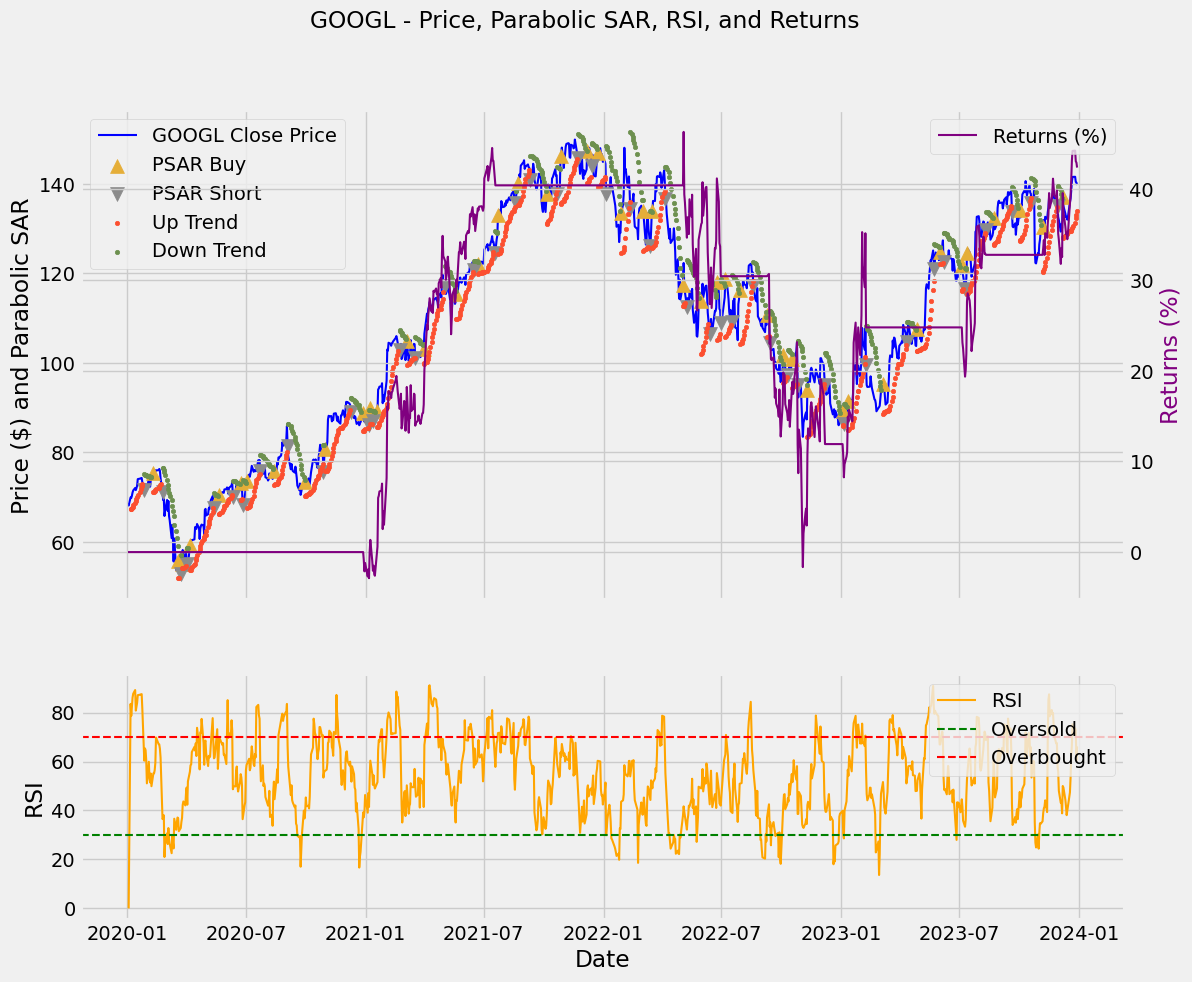

In [1411]:
# initialize start and end dtaes and tickers
start_date = '2020-01-01'
end_date = '2024-01-01'
tickers = ['MSFT', 'AMZN', 'AAPL', 'TSLA', 'GOOGL', 'META', 'NVDA', 'AMD', 'JPM', 'BAC', 'WFC', 'WMT', 'PG', 'KO', 'MCD', 'COST']

# gather price data for different tickers
data3 = clean_data(tickers[1], start_date, end_date)
data4 = clean_data(tickers[3], start_date, end_date)
data5 = clean_data(tickers[4], start_date, end_date)

# function to do everything from calculating data to plotting graphs
def analyze_indicators(data, ticker, window=5):
    # gather data and signals for the PSAR and RSI indicators
    psar_data = get_psar_data(data, ticker)
    rsi_signals = rsi_list(data, ticker)

    # customize the singals so that only singles that are supported by both indicators remain
    signals = create_signals(data, psar_data, rsi_signals, window)
    data['final_buy_sigs'] = signals['final_buy_sigs']
    data['final_short_sigs'] = signals['final_short_sigs']
    
    # generate returns
    returns = generate_returns(data)
    
    # find the information and sharpe ratios
    sharpe_ratio = get_sharpe_ratio(data)
    information_ratio = calculate_information_ratio(data['returns'], start_date, end_date)
    print(f"Sharpe Ratio: {sharpe_ratio}")
    print(f"Information Ratio: {information_ratio}")

    # plot the returns along with closing prices and both indicators
    plot_returns(data, ticker, psar_data, rsi_signals)

# analyze the three tickers
analyze_indicators(data3, tickers[1], 5)
analyze_indicators(data4, tickers[3], 5)
analyze_indicators(data5, tickers[4], 5)

## **8. Strategy Effectiveness**

### **8.1 Sharpe Ratio**

In [1373]:
# function to calculate the sharpe ratio based on a given risk free rate
def get_sharpe_ratio(prices, rf=0.02):
    # calculate average returns
    average_returns = np.mean(prices['returns'])

    # calculate excess returns
    excess_returns = average_returns - rf

    # find the standard deviation
    std_dev = np.std(prices['returns'])

    # find and return the sharpe ratio
    sharpe_ratio = excess_returns / std_dev
    return sharpe_ratio
    

### **8.2 Information Ratio**

In [1375]:
def calculate_information_ratio(portfolio_returns, start_date, end_date):
    # Download S&P 500 benchmark returns
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    sp500['Benchmark Returns'] = sp500['Adj Close'].pct_change().dropna()

    # Align portfolio returns and benchmark returns by date
    portfolio_returns = portfolio_returns.loc[sp500.index]

    # Calculate the excess returns (portfolio - benchmark)
    excess_returns = portfolio_returns - sp500['Benchmark Returns']

    # Calculate the average excess return
    average_excess_return = np.mean(excess_returns)

    # Calculate the tracking error (standard deviation of excess returns)
    tracking_error = np.std(excess_returns)

    # Calculate the Information Ratio
    information_ratio = average_excess_return / tracking_error

    return information_ratio